In [29]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from classes.pandas_api import APIPandas

#Redability
rename = {
          'fullVisitorId':'UserId',
          'device.operatingSystem':'OS',
          'device.browser':'Browser',
          'device.deviceCategory':'DeviceType',
          'channelGrouping':'Channel',
          'weekend_prop':'%Weekend',
          'device.isMobile':'isMobile',
          'totals.hits':'Events',
          'totals.pageviews':'PageViews',
          'bounce_prop':'%Bounce',
          'trafficSource.medium':'Source'
          }

dataset = pd.read_csv('./data_customers.csv')
dataset = dataset.rename(columns=rename)
dataflow = APIPandas(dataset)

In [30]:
# Información general del dataset
dataflow.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9996 entries, 0 to 9995
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   UserId      9996 non-null   uint64  
 1   Channel     9996 non-null   category
 2   %Weekend    9996 non-null   float64 
 3   hour        9996 non-null   float64 
 4   sessionId   9996 non-null   int64   
 5   Browser     9996 non-null   category
 6   DeviceType  9996 non-null   category
 7   isMobile    9996 non-null   float64 
 8   OS          9996 non-null   category
 9   Events      9996 non-null   float64 
 10  PageViews   9996 non-null   float64 
 11  %Bounce     9996 non-null   float64 
 12  Source      8147 non-null   category
 13  HourBins    9996 non-null   category
dtypes: category(6), float64(6), int64(1), uint64(1)
memory usage: 685.2 KB


In [31]:
# Estadísticas descriptivas
dataflow.data.describe(include=float).map('{:.2f}'.format)

,%Weekend,hour,isMobile,Events,PageViews,%Bounce
count,9996.00,9996.00,9996.00,9996.00,9996.00,9996.00
mean,0.15,14.45,0.10,22.18,17.53,0.08
std,0.30,6.26,0.30,21.92,16.26,0.16
min,0.00,0.00,0.00,1.00,1.00,0.00
25%,0.00,11.00,0.00,9.00,8.00,0.00
50%,0.00,16.50,0.00,17.00,14.00,0.00
75%,0.13,19.00,0.00,28.00,22.50,0.08
max,1.00,23.00,1.00,500.00,466.00,0.93


#### Categorizacion
La hora es un paramentro se segmentacion ganador que vale le pena analizar exautivamente para llegar a las conclusiones correctas de manera que se realizara un conjunto de evaluciones sobre la mismo presentadas a continuacion.
1. La hora es una feature que se puede categorizar en bins y posteriormente aplicar un one hot encoder.
2. La hora categorica se usara como input del modelo de segmentacion esto ayudara a que los segmentos tengan elementos diferenciadores.
3. La hora numerica sera estudiada en terminos de probabilidades usando scipy.

El analsis probabilistico de la hora puede ser mas util que un analisis frecuencias para esto se hace uso de KDE (Kernel Density Estimate) para estimar la proabilidad y segmentarla por diferentes categorias usando una la siguiente visualizacion en la cual se puede cambiar dinamicamente la categoria sobre la cual se esta evaluando la hora.


Haz clic para ver los detalles
Selecciona la categoria que desees para ver la distribucion de probabilidad a nivel general

Haz clic para ver los detalles
Selecciona la categoria que desees para ver la distribucion de probabidad abierto por la actegoria seleccionada.


Haz clic para ver las consideraciones

Insights
1. Aprox el 42% de los usuarios de la muestra ubicados en el canal de referidos tiene una median a las 17:30 aprox. con una probabilidad aprox de 12% pero una desviacion estandar del casi 6 horas, por lo que usar el canal como categoria se segmentacion para la hora no es lo sufucientemente definitivo.
2. Algo similar ocurre a nivel de navegador donde pueden haber alguos outliers pero no se condidera significtivo ya que se agrupa en menos del 5% de la muestra
3. Aunque estimar la probabiliad de en la hora para intervalos de hora (categoria) puede sonar redundante esto permite dar mas claridad encuanto a probabilidad y segmentacion. Es asi que se identifica que un 24.4% de los usuarios de la muestra en el intervalo de 15:00 a 17:59  tienen una probabilidad del 30% de entrar a las 17:00 por lo que seria util general una call to action usando email marketing o sms puede que sea justo la hora en la que estos usuarios terminan su jornada laboral y puede revisar desde su dektop temas personales.
4. Aunque la medida de tencia central es 17:30 aprox. En el intervalo de 21:00 - 23:59 hay una probabilidad del 40% aprox de que el 12% de la muestra de usuarios ingresen a las 21:00 o 22:00 p.m.

Haz clic para 

In [32]:
dataflow.data.columns

Index(['UserId', 'Channel', '%Weekend', 'hour', 'sessionId', 'Browser',
       'DeviceType', 'isMobile', 'OS', 'Events', 'PageViews', '%Bounce',
       'Source', 'HourBins'],
      dtype='object')

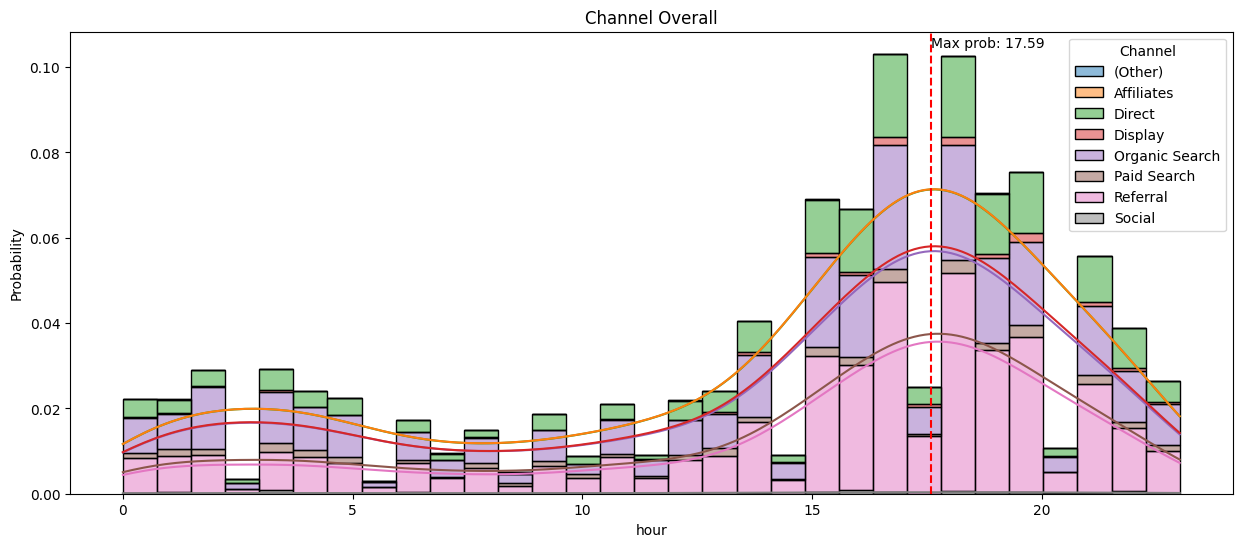

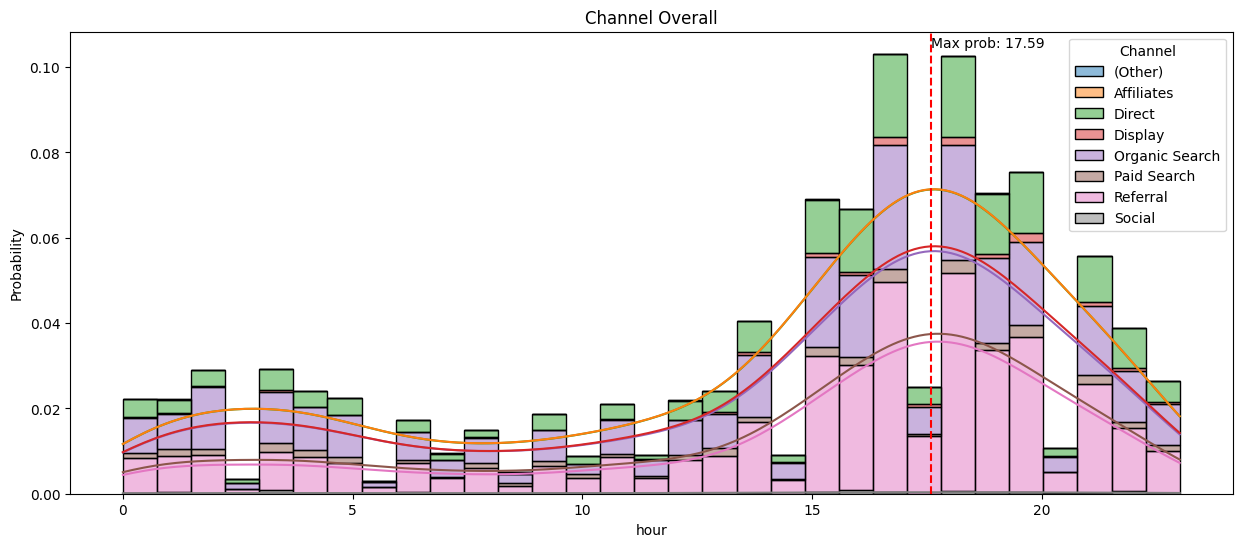

In [33]:
dataflow.hourkde_overall('Channel')

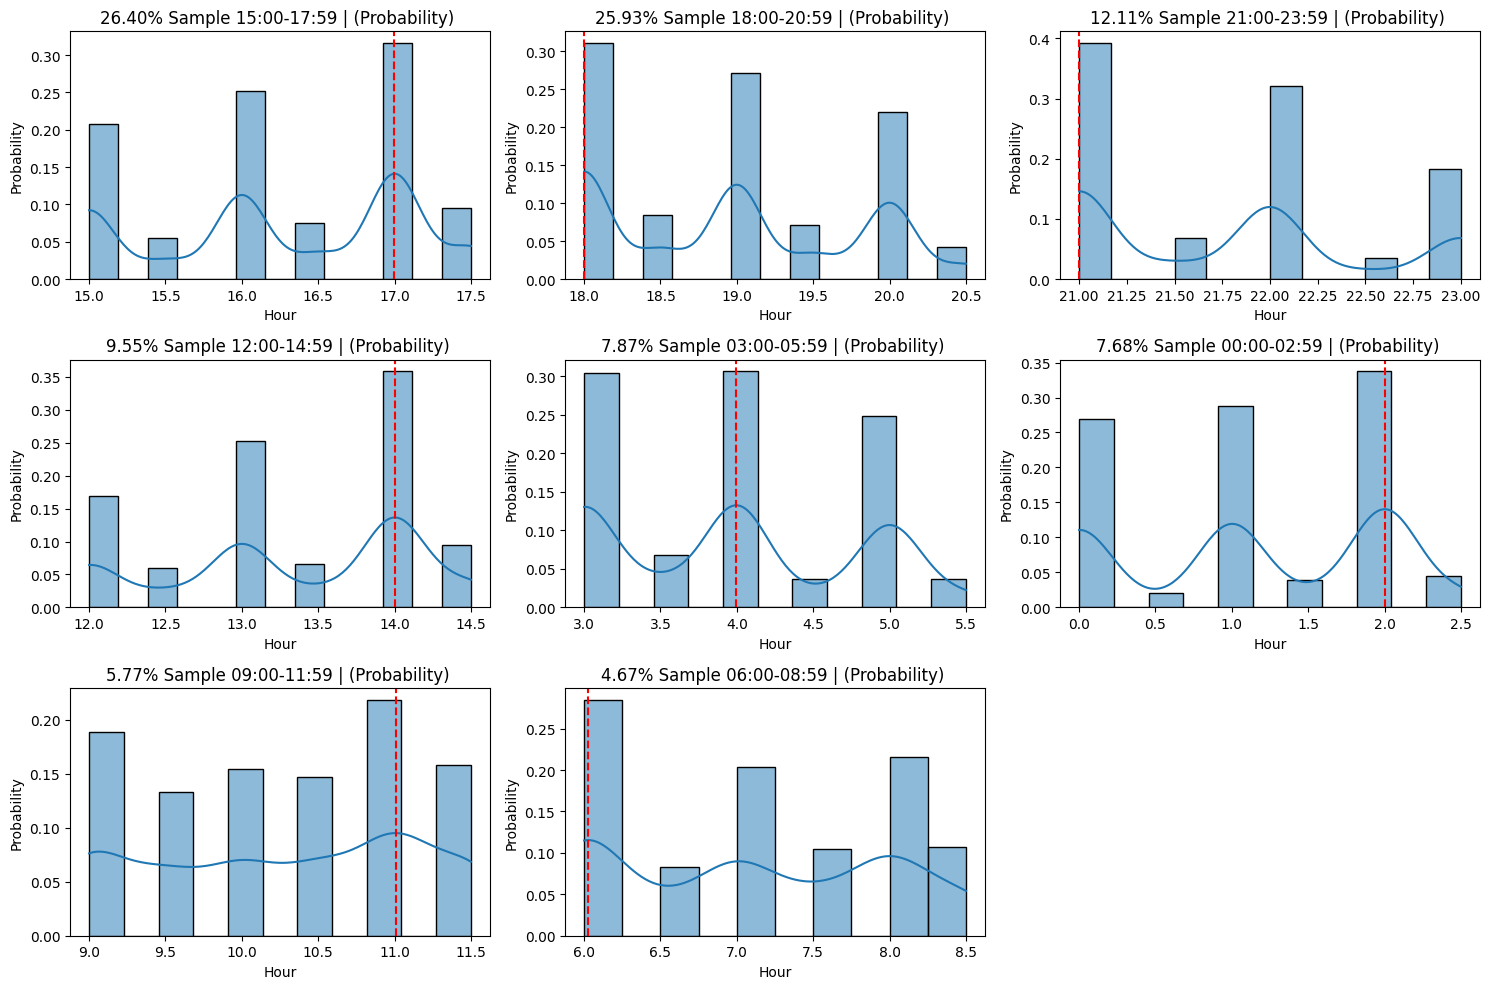

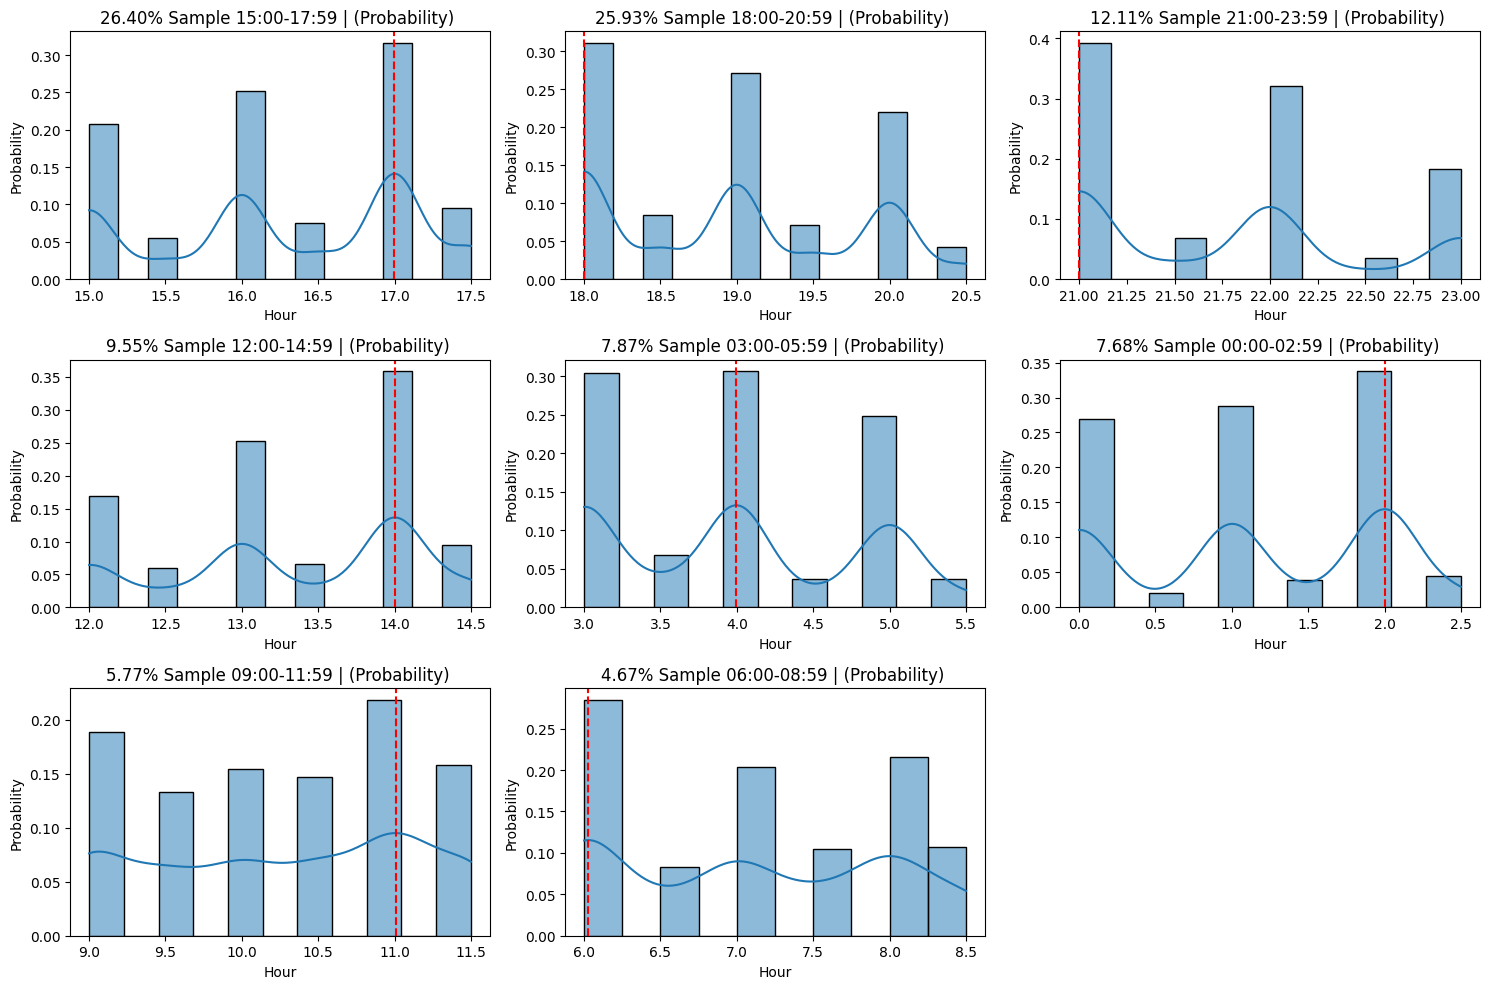

In [34]:
dataflow.single_hourkde('HourBins')

### Manejo valores nulos
Una de las definiciones que mas de ajustan a el caso de `trafficSource.medium` es Missing not at Random (MNAR) esto quiere decir que hay un patron de en los valores faltantes esto se puede observa con `missingno.matrix` 

1. La columna `trafficSource.medium` tiene el valor (none) por lo que se procese a mapearlo como un valor nulo.
2. No hay una distribucion aleatoria de este valor sino que por el contrario todo esta concentrado en el canal Direct.
3. Direct es un canal con 1850 muestras cuyos usuarios se pueden deber a un buen trabajo de campanas offline o incluso a referidos que no logran mapearse en google analytics. No se eliminaran ni imputaran valores a este campo por el contrario se usara como fuente de verdad el canal unicamente.

haz clic para ver mas detalles

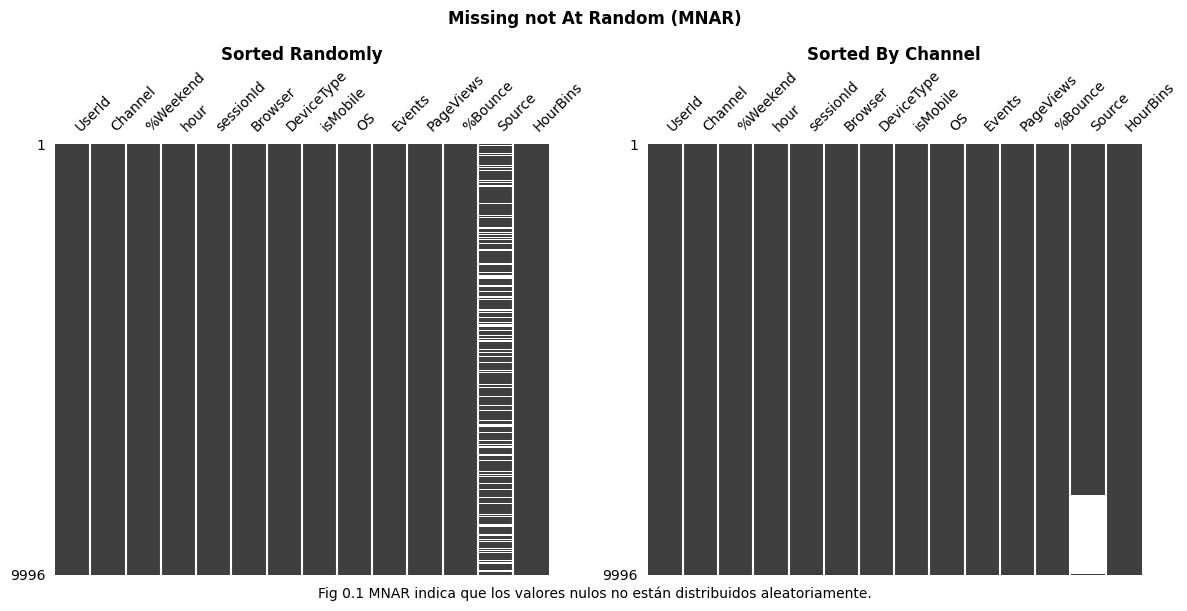

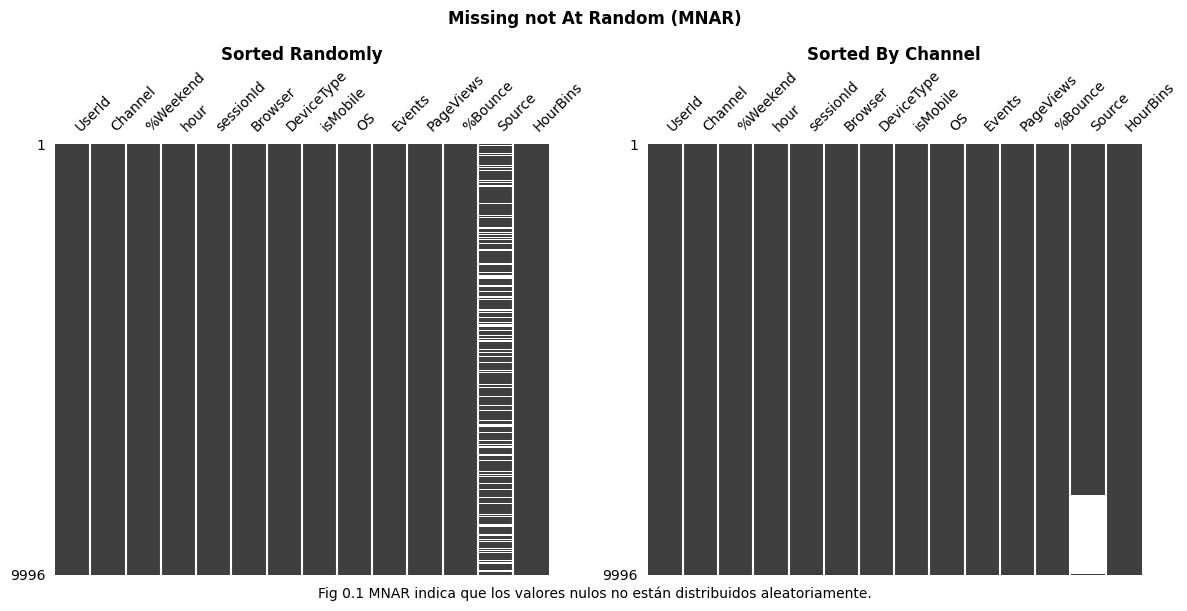

In [35]:
dataflow.null_chart()

# Entidimiento de Weekend Proportion
Las transacciones los fines de semana pueden ser generadar por usuarios en su tiempo libre e identificar en como mejorar el trafico en estos casos es fundamental asi que a continuacion se evalua lo que seria una proximacion a una distribucion de trafico entre dias de la semana y fines de semana.Los datos presentados en la metrica weekend_prop se consideran como una metrica calculada por google analytics que agrega la cantidad de visitas los fines de semana por lo que el complento seria los dias entre semana, entonces la pregunta contcreta para realizar este analisis es ¿Hay diferencias notables en el tráfico y el comportamiento de los usuarios durante los fines de semana?

Haz clic para ver las consideraciones

1. Los usuarios de IOS que represental el 5.19% de la muestra tiene una trafico del 27%aprox los fines de semana esto quiere decir que hay una oportunidad de incrementar el trafico de machintos al ser usurios que puede que compartir el mismo proveerdor tecnologico en este caso apple. 
2. Safari & safari in-app representan aprox 7.30% de los usuarios de la muestra y es el medio preferido para realizar visitas el tiempos libres los fines de semana, esto es relevante ya que se puden aprender de la UX que se ofrese safari para que mas usuarios visitan la pagina los fines de semana.
3. Si bein desktop es el dispositivo Mobile que genera mayor trafico se debe insentivas mas campanas que tipo push notifications, o sms los fines de semana para aumetar el trafico en dispositivos como Tablets y Mobile
4. El bajo trafico en dispositivos de bolsillos puede sugerir que se debe trabajar en responsive design. 
5. Aunque el CPC y el CPM generan el 7.5% aprox del trafico de usuarios se suguiere que se trate de aumetar esfierzos para los fines de semana donde puede haber una mayor mercado y sin preocuparse ya que mas del 85% de los usuarios se cubren por fuentes organicas y de referidos.
6. La hora tambien es un factor claro para activa a esto usuarios en especial en horas de la manana donde se observa mayor tiempo libre.
haz clic para ver los graficos

In [36]:
dataflow.data.columns

Index(['UserId', 'Channel', '%Weekend', 'hour', 'sessionId', 'Browser',
       'DeviceType', 'isMobile', 'OS', 'Events', 'PageViews', '%Bounce',
       'Source', 'HourBins'],
      dtype='object')

In [37]:
# dataflow.weekend_weekday_rate('OS', '%Weekend',2,4)
# dataflow.weekend_weekday_rate('Browser', '%Weekend',2,5)
# dataflow.weekend_weekday_rate('DeviceType', '%Weekend',1,3)
# dataflow.weekend_weekday_rate('Source', '%Weekend',2,4)
# dataflow.weekend_weekday_rate('Channel', '%Weekend',2,4)
# dataflow.weekend_weekday_rate('HourBins', '%Weekend',2,4)

# Análisis de Contribución %Bounce Rate
Este este modulo permite realizar decomposiciones de forma dinamica para entender la participacion de una variable catogorica dentro de otra variable esto se realiza usando %Bounce Rate metrica calculada por google analytics y estimando su participacion es valores abolutos es decir se realiza una sumatoria y en base al total se realza una atribucion a cada variable categorica segun corresponda.  

haz clic para ver las consideraciones

Insights
1. La tasa rebote en terminos absolutos es del 99% del 4% aprx de la muestra usaurios desktop de usuarios que llegaron por el canal de referidos por lo que vale la pena identificar a adetalle cuales fueron los refericos en caso se ser posible y validar la calidad de los mismos.
2. Se debe establecer un OKR en el que se pueda bajar la cantidad de tasas de rebote del 4% hasta un 2% en cada uno de los canales, lo que enterminos de trafico puede puede representar aumentar la retension de los usuarios.

Haz clik para para ver los graficos

In [38]:
dataflow.barplot(yaxis='OS',xaxis='DeviceType',metric='%Bounce',aggr='sum')

In [39]:
dataflow.metrics_viewer('Channel','Browser','PageViews','sum')

PageViews %Sum By Browser %Sum By Channel
Channel Browser                                                     
(Other) Amazon Silk              0.0           0.00%           0.00%
        Android Webview          0.0           0.00%           0.00%
        Chrome                  16.0           0.01%         100.00%
        Edge                     0.0           0.00%           0.00%
        Firefox                  0.0           0.00%           0.00%
...                              ...             ...             ...
Social  Firefox                 64.5           2.07%           4.97%
        Internet Explorer        9.5           0.58%           0.73%
        Opera                    0.0           0.00%           0.00%
        Safari                 185.5           1.51%          14.28%
        Safari (in-app)         21.0          16.03%           1.62%

[72 rows x 3 columns]

In [40]:
dataflow.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9996 entries, 0 to 9995
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   UserId      9996 non-null   uint64  
 1   Channel     9996 non-null   category
 2   %Weekend    9996 non-null   float64 
 3   hour        9996 non-null   float64 
 4   sessionId   9996 non-null   int64   
 5   Browser     9996 non-null   category
 6   DeviceType  9996 non-null   category
 7   isMobile    9996 non-null   float64 
 8   OS          9996 non-null   category
 9   Events      9996 non-null   float64 
 10  PageViews   9996 non-null   float64 
 11  %Bounce     9996 non-null   float64 
 12  Source      8147 non-null   category
 13  HourBins    9996 non-null   category
dtypes: category(6), float64(6), int64(1), uint64(1)
memory usage: 685.2 KB


El algoritmo de segmentacion 

# Correlacion
Es importante identificar que paramentros tienen una alta correlacion es decir que aportan practicamente la misma informacion al modelo.

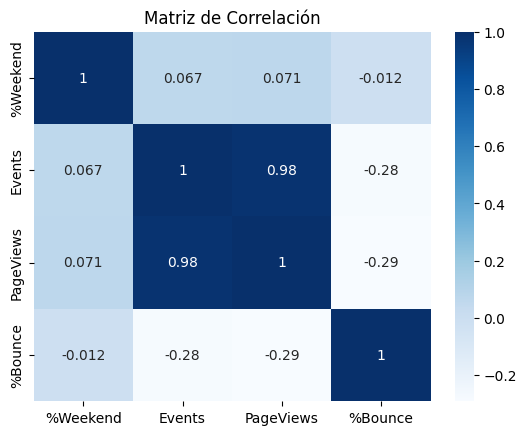

In [41]:
data = dataflow.data
numeric_features = ['%Weekend', 'Events', 'PageViews', '%Bounce']
categorical_features = ['Channel', 'Browser', 'DeviceType', 'OS', 'Source','HourBins']

correlation_matrix = data[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="Blues")
plt.title("Matriz de Correlación")
plt.show()

¿Por qué una baja varianza puede ser problemática?

Poca información: Una característica con baja varianza tiene valores muy similares en todas las observaciones. Esto significa que no discrimina bien entre diferentes grupos o categorías, y por lo tanto, aporta poca información al modelo.
Ruido: En algunos casos, una baja varianza puede indicar que la característica es principalmente ruido aleatorio, lo que puede confundir al modelo y empeorar su rendimiento.

In [42]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score
import joblib


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans


preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
X = preprocessor.fit_transform(dataflow.data)
X = X.toarray()


In [43]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.009)
X_selected = selector.fit_transform(X)

original_feature_names = list(numeric_features) + list(preprocessor.named_transformers_['categorical'].get_feature_names_out(categorical_features))
removed_feature_indices = np.where(~selector.get_support())[0]
removed_features = [original_feature_names[i] for i in removed_feature_indices]
removed_features

['Channel_(Other)',
 'Channel_Affiliates',
 'Channel_Social',
 'Browser_Amazon Silk',
 'Browser_Android Webview',
 'Browser_Edge',
 'Browser_Opera',
 'Browser_Safari (in-app)',
 'OS_Windows Phone',
 'Source_affiliate']

Gráfico del Codo
- Se busca un punto en el gráfico donde la disminución de la inercia se vuelve menos pronunciada, formando un "codo". Este punto sugiere un número óptimo de clusters, ya que agregar más clusters no reduciría significativamente la inercia y podría llevar al sobreajuste.

Índice de Calinski-Harabasz:

- El índice de Calinski-Harabasz (CH) es una métrica que mide la relación entre la dispersión entre clusters y la dispersión dentro de los clusters. Un valor más alto del índice CH indica una mejor estructura de clustering, con clusters más densos y bien separados.

Silhouette Score:

- El Silhouette Score (SS) es una métrica que mide qué tan similar es un punto de datos a su propio cluster en comparación con otros clusters.
- Se calcula para cada punto de datos y luego se promedia para obtener un valor global que representa la calidad general del clustering.
- Un valor de Silhouette cercano a 1 indica que el punto está bien emparejado con su propio cluster y está lejos de los otros clusters, lo que sugiere una buena estructura de clustering.
- Un valor cercano a 0 indica que el punto está cerca del límite entre dos clusters, lo que podría indicar una superposición o una separación poco clara entre los clusters.


# Kmeans
Usando Kmeans y la grafica de codo donde se grafica la inercia que es la suma de las distancias cuadradas de cada punto de datos a su centroide asignado se puedria llegar a estimar que la cantidad de clusters adecuado es k=7 sin emmbargo usando Silhouette Score se llega a la conclusion de que el cluster que matiene una mejor separacion moderada es k=6.
- Silhouette Score para k=5 es 0.186
- Silhouette Score para k=6 es 0.214
- Silhouette Score para k=7 es 0.212
- Silhouette Score para k=8 es 0.207
- Silhouette Score para k=9 es 0.194

Summary 
- Coeficiente de silueta (silhouette_score): Mide qué tan similares son los puntos dentro de un clúster en comparación con otros clústeres.
- Índice Davies-Bouldin (davies_bouldin_score): Evalúa la separación entre clústeres y su compacidad.
- Calinski-Harabasz (calinski_harabasz_score): Mide la relación entre la dispersión dentro de los clústeres y la dispersión entre clústeres.

Número óptimo de clusters (Codo): 14
Número óptimo de clusters (Calinski-Harabasz): 5
Número óptimo de clusters (Silhouette): 6
Silhouette Score para k=6: 0.214
Índice de Calinski-Harabasz para k=6: 1731.681


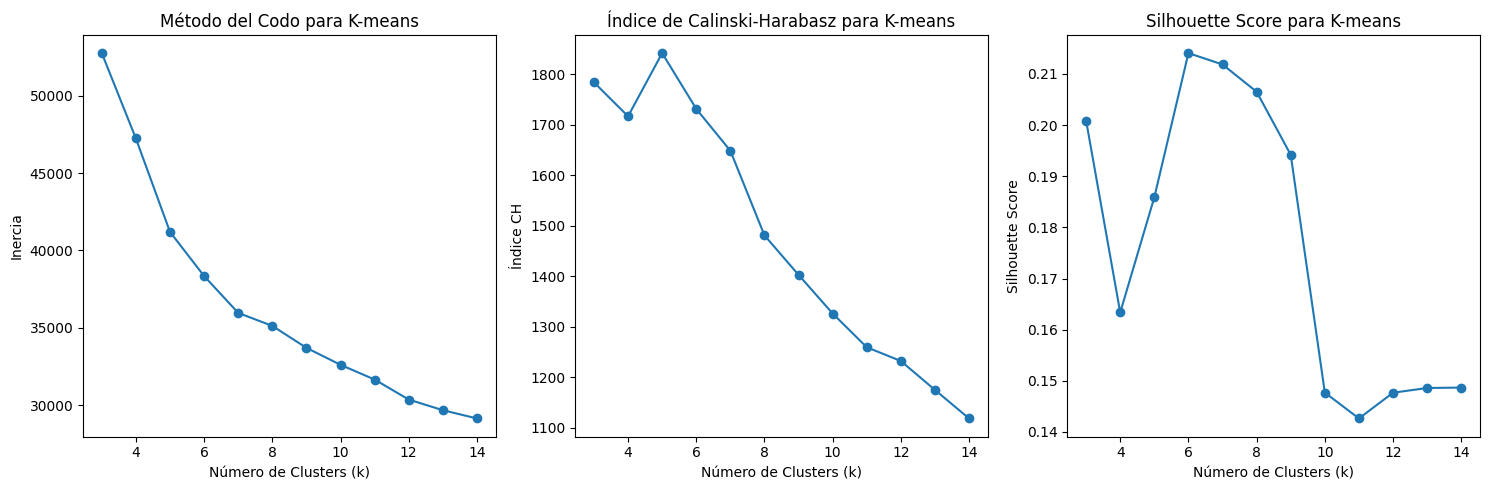

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

inertias = []
ch_scores = []
silhouette_scores = []
k_values = range(3, 15)  # Ajusta el rango de valores de k según tus necesidades

# Calcular métricas para cada valor de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_selected)
    inertias.append(kmeans.inertia_)
    ch_scores.append(calinski_harabasz_score(X_selected, cluster_labels))
    silhouette_avg = silhouette_score(X_selected, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Encontrar el valor óptimo de k (considerando ambas métricas)
optimal_k_elbow = k_values[np.argmin(inertias)]  # Codo
optimal_k_ch = k_values[np.argmax(ch_scores)]    # Calinski-Harabasz
optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]  # Silhouette


optimal_k = optimal_k_silhouette 


kmeans = KMeans(n_clusters=optimal_k, random_state=42) 
kmeans.fit(X_selected)

# joblib.dump(preprocessor, 'models/preprocessor.joblib')
# joblib.dump(selector, 'models/selector.joblib')
# joblib.dump(kmeans, 'models/kmeans_model.joblib')

# kmeans = KMeans(n_clusters=optimal_k, random_state=42)
# cluster_labels = kmeans.fit_predict(X_selected)


# Imprimir resultados
print(f"Número óptimo de clusters (Codo): {optimal_k_elbow}")
print(f"Número óptimo de clusters (Calinski-Harabasz): {optimal_k_ch}")
print(f"Número óptimo de clusters (Silhouette): {optimal_k_silhouette}")
print(f"Silhouette Score para k={optimal_k}: {silhouette_scores[optimal_k - k_values[0]]:.3f}")
print(f"Índice de Calinski-Harabasz para k={optimal_k}: {ch_scores[optimal_k - k_values[0]]:.3f}")


# Graficar las métricas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Método del codo
axes[0].plot(k_values, inertias, marker='o')
axes[0].set_title("Método del Codo para K-means")
axes[0].set_xlabel("Número de Clusters (k)")
axes[0].set_ylabel("Inercia")

# Índice de Calinski-Harabasz
axes[1].plot(k_values, ch_scores, marker='o')
axes[1].set_title("Índice de Calinski-Harabasz para K-means")
axes[1].set_xlabel("Número de Clusters (k)")
axes[1].set_ylabel("Índice CH")

# Silhouette Score
axes[2].plot(k_values, silhouette_scores, marker='o')
axes[2].set_title("Silhouette Score para K-means")
axes[2].set_xlabel("Número de Clusters (k)")
axes[2].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

Gaussian Mixture Models (GMM)

- GMM puede modelar clusters de diferentes formas y tamaños, incluyendo clusters superpuestos.
- Probabilidades de pertenencia: Asigna a cada punto de datos una probabilidad de pertenecer a cada cluster, lo que proporciona una medida de incertidumbre útil.
- Número de clusters: Puede determinar automáticamente el número óptimo de clusters utilizando criterios como el **criterio de información bayesiano (BIC)** o el criterio de información de Akaike (AIC).

¿Cómo funciona el BIC?

- El BIC se basa en la verosimilitud del modelo, que es una medida de qué tan bien el modelo se ajusta a los datos observados. Sin embargo, el BIC también penaliza la complejidad del modelo, es decir, el número de parámetros que utiliza. Esto evita que el modelo se sobreajuste a los datos y selecciona un modelo que generalice bien a nuevos datos.
- La disminución en el BIC se vuelve menos pronunciada después de k=3 o k=4.  Esto podría indicar que añadir más clústeres más allá de este punto no mejora significativamente el modelo y podría estar llevando a un sobreajuste (el modelo se ajusta demasiado al ruido en los datos, en lugar de a los patrones subyacentes).


Optimal Number of Clusters (BIC): 9


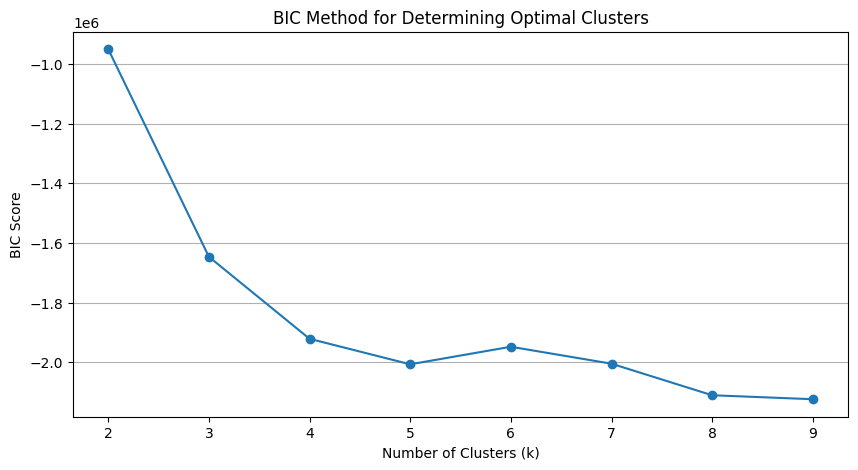

In [46]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

k_values = range(2, 10)  
bic_scores = []

for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_selected)
    bic_scores.append(gmm.bic(X_selected))

optimal_k = k_values[np.argmin(bic_scores)] 

gmm_final = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_final.fit(X_selected)
# joblib.dump(gmm_final, 'models/gmm_model.joblib')

print(f"Optimal Number of Clusters (BIC): {optimal_k}")

fig, ax = plt.subplots(figsize=(10, 5)) 
ax.plot(k_values, bic_scores, marker='o')
ax.set_title("BIC Method for Determining Optimal Clusters")
ax.set_xlabel("Number of Clusters (k)")
ax.set_ylabel("BIC Score")
ax.set_xticks(k_values)                
plt.grid(axis='y')                
plt.show()


# Mean Shift:

- Enfoque: Es un algoritmo basado en densidad que busca los modos (puntos de mayor densidad) en la distribución de los datos.
- Ventajas: No requiere especificar el número de clústeres, puede encontrar clústeres de formas arbitrarias y es relativamente robusto al ruido.
- Desventajas: Puede ser computacionalmente costoso para grandes conjuntos de datos y la elección del ancho de banda (bandwidth) puede ser crucial.

¿Qué es el ancho de banda en Mean Shift?

El ancho de banda (bandwidth) es un hiperparámetro fundamental en el algoritmo Mean Shift. Define el tamaño de la ventana o región esférica alrededor de cada punto de datos en la que se calculará la media (mean shift). Esta media se utiliza para actualizar iterativamente la posición del punto hacia áreas de mayor densidad.

Ancho de banda pequeño: La ventana será pequeña, lo que significa que solo se considerarán los puntos muy cercanos para calcular la media. Esto puede llevar a encontrar muchos clústeres pequeños y densos, pero también puede ser más sensible al ruido en los datos.

Ancho de banda grande: La ventana será grande, abarcando más puntos en el cálculo de la media. Esto puede llevar a encontrar menos clústeres, pero los clústeres serán más grandes y menos sensibles al ruido.

- Selección del cuantil: El parámetro quantile (que va de 0 a 1) determina qué porcentaje de las distancias se considerará. Por ejemplo, quantile=0.3 significa que se tomará el 30% de las distancias más pequeñas.
- Un quantile más bajo (por ejemplo, 0.1) resultará en un ancho de banda más pequeño, lo que favorecerá la detección de clústeres más pequeños y densos.
Un quantile más alto (por ejemplo, 0.5) resultará en un ancho de banda más grande, lo que favorecerá la detección de clústeres más grandes y menos sensibles al ruido.

Número de clusters encontrados: 6


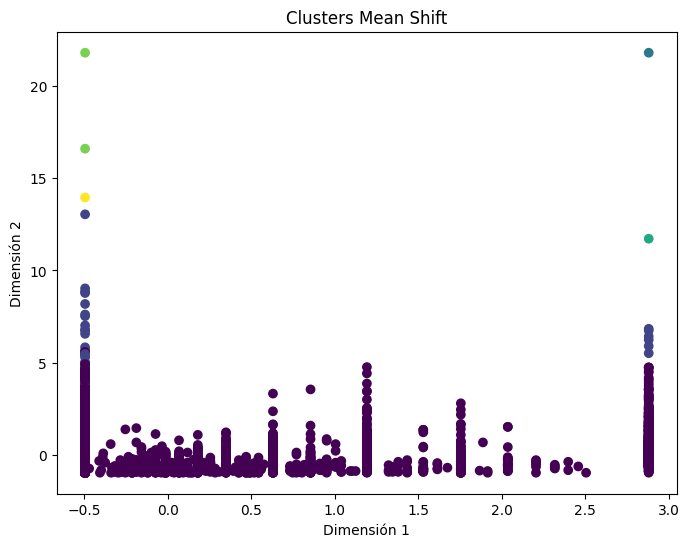

In [47]:
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

# Estimar el ancho de banda (bandwidth) automáticamente
bandwidth = estimate_bandwidth(X_selected, quantile=0.3)  # Ajusta el cuantil según tus datos

# Aplicar Mean Shift
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)  # bin_seeding para acelerar el cálculo
cluster_labels = ms.fit_predict(X_selected)

filename = 'models/meanshift_model.joblib' 
# joblib.dump(ms, filename)

# Obtener el número de clusters encontrados
n_clusters = len(np.unique(cluster_labels))
print(f"Número de clusters encontrados: {n_clusters}")

# Visualizar los clusters (asumiendo que X_selected tiene 2 dimensiones)
plt.figure(figsize=(8, 6))
plt.scatter(X_selected[:, 0], X_selected[:, 1], c=cluster_labels, cmap='viridis')
plt.title("Clusters Mean Shift")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.show()

Suposiciones sobre la forma de los clústeres:

- **K-Means:** Asume que los clústeres son esféricos y de tamaño similar.
- **Mean Shift:** No hace suposiciones sobre la forma de los clústeres, pero puede tener dificultades con clústeres de densidades muy diferentes.
- **GMM:** Asume que los clústeres son gaussianos (distribución normal), lo que le permite encontrar clústeres de diferentes formas y tamaños, pero puede ser sensible a valores atípicos.


Criterios de optimización:

- **K-Means:** Minimiza la suma de las distancias cuadradas entre los puntos y sus centroides asignados.
- **Mean Shift:** Busca los modos (puntos de mayor densidad) en la distribución de los datos.
- **GMM:** Maximiza la probabilidad (verosimilitud) de los datos dados los parámetros del modelo.

Sensibilidad a la inicialización:

- **K-Means:** Los resultados pueden variar dependiendo de la inicialización aleatoria de los centroides.
- **Mean Shift:** Menos sensible a la inicialización, pero la elección del ancho de banda puede influir en los resultados.
- **GMM:** También puede ser sensible a la inicialización, aunque en menor medida que K-Means.

In [48]:

rename = {
        'fullVisitorId':'UserId',
        'device.operatingSystem':'OS',
        'device.browser':'Browser',
        'device.deviceCategory':'DeviceType',
        'channelGrouping':'Channel',
        'weekend_prop':'%Weekend',
        'device.isMobile':'isMobile',
        'totals.hits':'Events',
        'totals.pageviews':'PageViews',
        'bounce_prop':'%Bounce',
        'trafficSource.medium':'Source'
        }

dataset = pd.read_csv('./data_customers.csv')
dataset = dataset.rename(columns=rename)
dataflow = APIPandas(dataset)


In [49]:
import joblib

def predict_clusters(data,model):
    preprocessor = joblib.load('app/models/preprocessor.joblib')
    selector = joblib.load('app/models/selector.joblib')
    kmeans = joblib.load(f'app/models/{model}_model.joblib')
    path = f'./app/batch/{model}.csv'

    X = preprocessor.transform(data)
    X = X.toarray()
    X_selected = selector.transform(X)
    
    clusters = kmeans.predict(X_selected)
    
    data_clusters = data.copy()
    data_clusters['Cluster'] = clusters
    
    data_clusters.to_csv(path,index=False)
    return data_clusters


models = ['kmeans','gmm','meanshift']
save_predictions = [predict_clusters(dataflow.data,model) for model in models]

In [50]:
import requests
import json

# URL de tu API en Railway
url = "https://web-production-a960.up.railway.app"

# Datos para la predicción
data = {
    "fullVisitorId": "0213131142648941",
    "channelGrouping": "Paid Search",
    "weekend_prop": 0.0,
    "hour": 22.0,
    "sessionId": 1,
    "device.browser": "Chrome",
    "device.deviceCategory": "desktop",
    "device.isMobile": 0.0,
    "device.operatingSystem": "Windows",
    "totals.hits": 100.0,
    "totals.pageviews": 50.0,
    "bounce_prop": 0.0,
    "trafficSource.medium": "(none)"
}

response = requests.post(url, json=data)
if response.status_code == 200:
    prediction = response.json()
    print("Predicción:", prediction)
else:
    print("Error en la solicitud:", response.status_code)
    print("Mensaje de error:", response.text)

In [54]:
import pandas as pd
from collections import Counter

# Cargar los datos
data = pd.read_csv('./app/batch/kmeans.csv')

clusters = data['Cluster'].value_counts()

cluster_insights = {}

for cluster in clusters.index:
    cluster_data = data[data['Cluster'] == cluster]
    channel_counts = cluster_data['Channel'].value_counts(normalize=True)
    avg_bounce = cluster_data['%Bounce'].mean()
    hour_bins = cluster_data['HourBins'].value_counts(normalize=True)
    distinctive_features = {
        'Channel': channel_counts.idxmax(),
        'AvgBounce': avg_bounce,
        'PeakHours': hour_bins.idxmax(),
        'AvgEvents': cluster_data['Events'].mean(),
        'AvgPageViews': cluster_data['PageViews'].mean(),
        'TopDevice': cluster_data['DeviceType'].mode().values[0],
        'TopOS': cluster_data['OS'].mode().values[0]
    }
    
    cluster_insights[cluster] = distinctive_features

marketing_data = []
for cluster, features in cluster_insights.items():
    for category, value in features.items():
        marketing_data.append((cluster, category, value))

for cluster, category, value in marketing_data:
    print(f"Cluster: {cluster}, Categoría: {category}, Valor: {value}")

Cluster: 1, Categoría: Channel, Valor: Referral
Cluster: 1, Categoría: AvgBounce, Valor: 0.03217996683518463
Cluster: 1, Categoría: PeakHours, Valor: 18:00-20:59
Cluster: 1, Categoría: AvgEvents, Valor: 17.856799759831883
Cluster: 1, Categoría: AvgPageViews, Valor: 14.3081657160012
Cluster: 1, Categoría: TopDevice, Valor: desktop
Cluster: 1, Categoría: TopOS, Valor: Macintosh
Cluster: 0, Categoría: Channel, Valor: Organic Search
Cluster: 0, Categoría: AvgBounce, Valor: 0.01987282415529753
Cluster: 0, Categoría: PeakHours, Valor: 15:00-17:59
Cluster: 0, Categoría: AvgEvents, Valor: 20.609579100145137
Cluster: 0, Categoría: AvgPageViews, Valor: 16.751330430575713
Cluster: 0, Categoría: TopDevice, Valor: desktop
Cluster: 0, Categoría: TopOS, Valor: Macintosh
Cluster: 2, Categoría: Channel, Valor: Direct
Cluster: 2, Categoría: AvgBounce, Valor: 0.01877688641998735
Cluster: 2, Categoría: PeakHours, Valor: 18:00-20:59
Cluster: 2, Categoría: AvgEvents, Valor: 19.061669829222012
Cluster: 2, Ca